In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!pip install scanpy squidpy anndata

In [4]:
import scanpy as sc
import pandas as pd
import os

data_path = "/content/drive/MyDrive/5243"

adata = sc.read_10x_h5(os.path.join(data_path, "151673_filtered_feature_bc_matrix.h5"))
adata.var_names_make_unique()
print(adata.shape)

pos = pd.read_csv(os.path.join(data_path, "tissue_positions_list.txt"), header=None)
pos.columns = ["barcode", "in_tissue", "array_row", "array_col", "pxl_row_in_fullres", "pxl_col_in_fullres"]
pos.set_index("barcode", inplace=True)

adata.obs = adata.obs.join(pos, how="left")
adata.obsm["spatial"] = adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(3639, 33538)


In [5]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.pca(adata, n_comps=30)

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

In [7]:
#pip install igraph louvain leidenalg

In [8]:
# Louvain
sc.tl.louvain(adata, resolution=1.0, key_added='louvain')

# Leiden
sc.tl.leiden(adata, resolution=1.0, key_added='leiden')

<ipython-input-8-106ce7e46a24>:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0, key_added='leiden')


In [9]:
print("Number of Louvain clusters:", adata.obs['louvain'].nunique())
print("Number of Leiden clusters:", adata.obs['leiden'].nunique())

Number of Louvain clusters: 9
Number of Leiden clusters: 11


In [10]:
print(adata.obsm["spatial"][:5])

[[8468 9791]
 [2807 5769]
 [9505 4068]
 [4151 9271]
 [7583 3393]]


In [11]:
import json
import matplotlib.pyplot as plt
import os

img = plt.imread(os.path.join(data_path, "tissue_hires_image.png"))

with open(os.path.join(data_path, "scalefactors_json.json"), "r") as f:
    scalefactors = json.load(f)

adata.uns["spatial"] = {
    "5243": {
        "images": {
            "hires": img
        },
        "scalefactors": scalefactors,
        "metadata": {
            "source_image_path": "tissue_hires_image.png"
        },
    }
}

<ipython-input-12-d66753c49d0b>:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


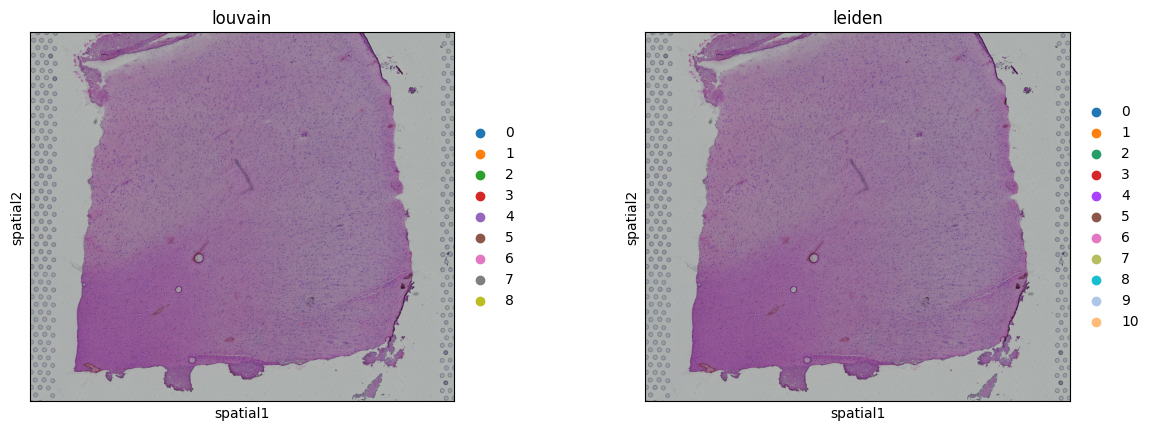

In [12]:
sc.pl.spatial(
    adata,
    color=["louvain", "leiden"],
    library_id="5243",
    spot_size=1.5,
    img_key="hires"
)

In [13]:
import pandas as pd
import os

meta = pd.read_csv(os.path.join(data_path, "metadata.tsv"), sep="\t")

print(meta.head())

print("\n列名（字段名）如下：")
print(meta.columns)

                               barcode  sample_name  tissue  row  col  \
AAACAACGAATAGTTC-1  AAACAACGAATAGTTC-1       151507       1    0   16   
AAACAAGTATCTCCCA-1  AAACAAGTATCTCCCA-1       151507       1   50  102   
AAACAATCTACTAGCA-1  AAACAATCTACTAGCA-1       151507       1    3   43   
AAACACCAATAACTGC-1  AAACACCAATAACTGC-1       151507       1   59   19   
AAACAGCTTTCAGAAG-1  AAACAGCTTTCAGAAG-1       151507       1   43    9   

                      imagerow    imagecol  Cluster  height  width  ...  \
AAACAACGAATAGTTC-1  113.141318  147.434749        6     600    600  ...   
AAACAAGTATCTCCCA-1  383.438357  413.051319        3     600    600  ...   
AAACAATCTACTAGCA-1  129.522957  231.008109        2     600    600  ...   
AAACACCAATAACTGC-1  431.188134  155.805586        5     600    600  ...   
AAACAGCTTTCAGAAG-1  344.869499  125.067511        1     600    600  ...   

                    SpatialDE_PCA_spatial  SpatialDE_pool_PCA_spatial  \
AAACAACGAATAGTTC-1                   

In [14]:
meta = pd.read_csv(os.path.join(data_path, "metadata.tsv"), sep="\t")
meta.set_index("barcode", inplace=True)

meta = meta[["layer_guess_reordered_short"]]

adata.obs = adata.obs.join(meta)

print(adata.obs["layer_guess_reordered_short"].value_counts(dropna=False))

layer_guess_reordered_short
L3     1070
L1      678
L5      573
L4      327
L6      325
WM      262
L2      246
NaN     158
Name: count, dtype: int64


In [32]:
# 清洗：同时保留有 ground truth 和聚类标签的数据点
adata_clean = adata[
    (~adata.obs['layer_guess_reordered_short'].isna()) &
    (~adata.obs['louvain'].isna()) &
    (~adata.obs['leiden'].isna())
].copy()

adata_clean.obsm["spatial"] = adata[adata_clean.obs_names].obsm["spatial"]
adata_clean.uns["spatial"] = adata.uns["spatial"]


In [38]:
adata_clean.obsm["spatial"] = adata[adata_clean.obs_names].obsm["spatial"]

In [33]:
print("Ground truth layer counts:\n", adata_clean.obs['layer_guess_reordered_short'].value_counts())
print("\nLouvain cluster count:", adata_clean.obs['louvain'].nunique())
print("Leiden cluster count:", adata_clean.obs['leiden'].nunique())


Ground truth layer counts:
 layer_guess_reordered_short
L3    1070
L1     678
L5     573
L4     327
L6     325
WM     262
L2     246
Name: count, dtype: int64

Louvain cluster count: 9
Leiden cluster count: 11


In [34]:
print("Spatial info shape:", adata_clean.obsm['spatial'].shape)

Spatial info shape: (3481, 2)


In [35]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari_louvain = adjusted_rand_score(
    adata_clean.obs['layer_guess_reordered_short'],
    adata_clean.obs['louvain']
)
nmi_louvain = normalized_mutual_info_score(
    adata_clean.obs['layer_guess_reordered_short'],
    adata_clean.obs['louvain']
)

print("Louvain ARI:", round(ari_louvain, 4))
print("Louvain NMI:", round(nmi_louvain, 4))

Louvain ARI: 0.1171
Louvain NMI: 0.2393


In [36]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari_louvain = adjusted_rand_score(
    adata_clean.obs['layer_guess_reordered_short'],
    adata_clean.obs['leiden']
)
nmi_louvain = normalized_mutual_info_score(
    adata_clean.obs['layer_guess_reordered_short'],
    adata_clean.obs['leiden']
)

print("leiden ARI:", round(ari_louvain, 4))
print("leiden NMI:", round(nmi_louvain, 4))


leiden ARI: 0.1098
leiden NMI: 0.2407


In [39]:
adata.obsm["spatial"] = adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values * hires_scalef

In [40]:
adata_clean.obsm["spatial"] = adata_clean.obsm["spatial"] * hires_scalef

<ipython-input-41-e846c13c9de3>:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_clean, color="layer_guess_reordered_short", ax=axs[0], show=False,
<ipython-input-41-e846c13c9de3>:4: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_clean, color="louvain", ax=axs[1], show=False,
<ipython-input-41-e846c13c9de3>:6: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_clean, color="leiden", ax=axs[2], show=False,


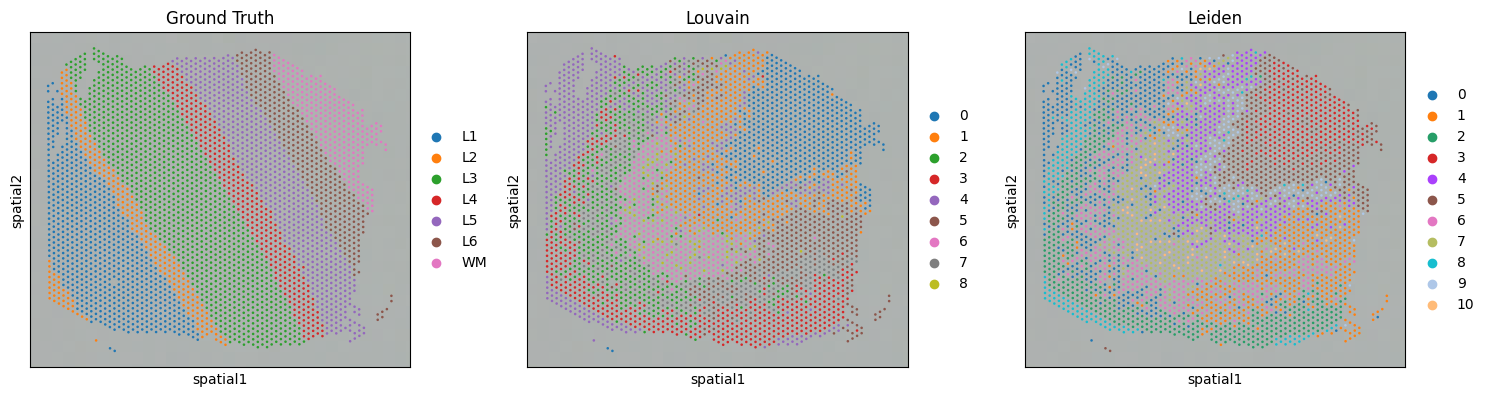

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sc.pl.spatial(adata_clean, color="layer_guess_reordered_short", ax=axs[0], show=False,
              title="Ground Truth", library_id="5243", img_key="hires", spot_size=1.5)
sc.pl.spatial(adata_clean, color="louvain", ax=axs[1], show=False,
              title="Louvain", library_id="5243", img_key="hires", spot_size=1.5)
sc.pl.spatial(adata_clean, color="leiden", ax=axs[2], show=False,
              title="Leiden", library_id="5243", img_key="hires", spot_size=1.5)
plt.tight_layout()
plt.show()
